# Analytics

#### Date: 2021/02

#### SUMMARY:

- Notebook dedicado a análise de qualidade dos códigos fontes do projeto Nortear Cartografias Sociais. Executado no smestre 2021/2

### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- 16/0142628	Rafaella Junqueira
- 17/0017885	Marcos Nery
- 16/0130883	Larissa Sales
- 17/0035158	Gustavo Marques
- 20/0073249	Pedro Vitor Augusto de Jesus
- 18/0119508	Eric Chagas de Oliveira
- 13/0111147	Gabriel do Nascimento de Carvalho
- 20/0019228	Gustavo Martins Ribeiro
- 19/0096373	Vinícius Alves de Sousa
- 19/0014776	Israel Thalles Dutra dos Santos
- 19/0055006	Gian Medeiros Rosa

### LIBRARIES

In [1]:
%pip install pandas
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

# Display pretty version of dataframe
from IPython.display import display, HTML

### GRAPH SETTINGS

In [3]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [5]:
jsons = glob('../analytics-raw-data/*/*.json', recursive=True) # add your path here
len(jsons)

20

In [6]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

In [7]:
def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021.2-Cartografia-social-(.*?)-[0-9]+-(.*?)-v(.*?).json", expand=True)  

    df['Repository'] = aux_df[1]

    df['Version'] = aux_df[3]
    
    df['Date'] = aux_df[2]

    df = df.sort_values(by=['Repository', 'Version'])
        
    return df


## Create base component dataframe


In [8]:
base_component_df = create_base_component_df(jsons)


/tmp/ipykernel_4098/4097731169.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_4098/4097731169.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_4098/4097731169.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_4098/4097731169.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_4098/4097731169.py:15: FutureWarning: The frame.append method is deprecated and w

In [9]:
base_component_df.head(12)

,metric,value,bestValue,filename,Repository,Version,Date
0,duplicated_lines_density,11.9,False,fga-eps-mds-2021-2-Cartografia-social-api-comu...,api-comunidades,1.1.0,15-2022-16-49-05
1,functions,68,NaN,fga-eps-mds-2021-2-Cartografia-social-api-comu...,api-comunidades,1.1.0,15-2022-16-49-05
2,test_execution_time,172,NaN,fga-eps-mds-2021-2-Cartografia-social-api-comu...,api-comunidades,1.1.0,15-2022-16-49-05
3,test_failures,0,True,fga-eps-mds-2021-2-Cartografia-social-api-comu...,api-comunidades,1.1.0,15-2022-16-49-05
4,test_errors,0,True,fga-eps-mds-2021-2-Cartografia-social-api-comu...,api-comunidades,1.1.0,15-2022-16-49-05
5,security_rating,1.0,True,fga-eps-mds-2021-2-Cartografia-social-api-comu...,api-comunidades,1.1.0,15-2022-16-49-05
6,tests,43,NaN,fga-eps-mds-2021-2-Cartografia-social-api-comu...,api-comunidades,1.1.0,15-2022-16-49-05
7,files,25,NaN,fga-eps-mds-2021-2-Cartografia-social-api-comu...,api-comunidades,1.1.0,15-2022-16-49-05
8,complexity,85,NaN,fga-eps-mds-2021-2-Cartografia-social-api-comu...,api-comunidades,1.1.0,15-2022-16-49-05
9,ncloc,840,NaN,fga-eps-mds-2021-2-Cartografia-social-api-comu...,api-comunidades,1.1.0,15-2022-16-49-05


#### Create dataframe per file

In [10]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [11]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')
        file_component_df_ts = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)
        file_component_df_ts['filename']= os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        df = df.append(file_component_df_ts, ignore_index=True)
        
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021.2-Cartografia-social-(.*?)-[0-9]+-(.*?)-v(.*?).json", expand=True)  

    df['Repository'] = aux_df[1]

    df['Version'] = aux_df[3]
    
    df['Date'] = aux_df[2]

    df = df.sort_values(by=['Repository', 'Version'])

    return df

In [12]:
file_component_df = create_file_df(jsons)
file_component_df.Repository.unique()

/tmp/ipykernel_4098/3909151359.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_4098/3909151359.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df_ts, ignore_index=True)
/tmp/ipykernel_4098/3909151359.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_4098/3909151359.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df_ts, ignore_index=True)
/tmp/ipykernel_4098/3909151359.py:45: FutureWarning: The frame.append method is deprecated

array(['api-comunidades', 'api-gateway', 'api-mapas', 'api-midia',
       'api-users', 'front'], dtype=object)

#### Create dataframe per repository

In [13]:
api_comunidades_df = file_component_df[file_component_df['Repository'] == 'api-comunidades']
api_gateway_df = file_component_df[file_component_df['Repository'] == 'api-gateway']
api_mapas_df = file_component_df[file_component_df['Repository'] == 'api-mapas']
api_midia_df = file_component_df[file_component_df['Repository'] == 'api-midia']
api_users_df = file_component_df[file_component_df['Repository'] == 'api-users']
front_df = file_component_df[file_component_df['Repository'] == 'front']

In [14]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [15]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [16]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [17]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Test coverage

In [18]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3 and m6 for each repository

In [19]:
def create_metrics_df(df):
    
    version_vec = df['Version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    dates_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['Version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['Repository'].iloc[0])
        dates_list.append(version_df['Date'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm6': m6_list,
                               'LOC': ncloc_list,
                               'Repository': repository_list, 
                               'Version': version_list,
                               'Date': dates_list
                               })
        
    return metrics_df

In [20]:
api_gateway_metrics = create_metrics_df(api_gateway_df)
front_metrics = create_metrics_df(front_df)
api_comunidades_metrics = create_metrics_df(api_comunidades_df)
api_mapas_metrics = create_metrics_df(api_mapas_df)
api_midia_metrics = create_metrics_df(api_midia_df)
api_users_metrics = create_metrics_df(api_users_df)

all_repo_measurements = [
    api_gateway_metrics,
    front_metrics,
    api_comunidades_metrics,
    api_mapas_metrics,
    api_midia_metrics,
    api_users_metrics
]  

for repo in all_repo_measurements:
    display(repo)

,m1,m2,m3,m6,LOC,Repository,Version,Date
0,0.361111,0.027778,1.0,0.750000,1084,api-gateway,1.1.0,18-2022-19-49-01
1,0.351351,0.027027,1.0,0.756757,1106,api-gateway,1.2.0,15-2022-04-02-19
2,0.368421,0.026316,1.0,0.736842,1216,api-gateway,2.0.0,03-2022-18-36-11


,m1,m2,m3,m6,LOC,Repository,Version,Date
0,0.742574,0.039604,0.851485,0.000000,5747,front,1.1.0,15-2022-17-57-12
1,0.742574,0.029703,0.891089,0.000000,5753,front,1.1.1,18-2022-19-54-49
2,0.742857,0.028571,0.895238,0.000000,5970,front,1.2.0,03-2022-19-01-24
3,0.742857,0.028571,0.895238,0.000000,5970,front,1.2.1,05-2022-18-31-02
4,0.742857,0.028571,0.895238,0.000000,5983,front,1.2.2,05-2022-19-28-53
5,0.747664,0.028037,0.878505,0.000000,6324,front,1.3.0,15-2022-04-09-05
6,0.745614,0.026316,0.868421,0.035088,6576,front,2.0.0,24-2022-18-43-30
7,0.745614,0.026316,0.868421,0.035088,6576,front,3.0.0,04-2022-23-57-46


,m1,m2,m3,m6,LOC,Repository,Version,Date
0,0.440000,0.0,0.960000,0.560000,840,api-comunidades,1.1.0,15-2022-16-49-05
1,0.440000,0.0,0.960000,0.560000,849,api-comunidades,1.1.1,18-2022-19-52-41
2,0.461538,0.0,0.961538,0.538462,983,api-comunidades,2.0.0,04-2022-23-11-16


,m1,m2,m3,m6,LOC,Repository,Version,Date
0,0.55,0.0,1.0,0.8,633,api-mapas,1.1.0,18-2022-19-24-41
1,0.55,0.0,1.0,0.8,665,api-mapas,2.0.0,04-2022-23-05-22


,m1,m2,m3,m6,LOC,Repository,Version,Date
0,0.777778,0.111111,1.0,0.555556,192,api-midia,1.1.0,18-2022-19-29-52


,m1,m2,m3,m6,LOC,Repository,Version,Date
0,0.700000,0.100000,1.0,0.600000,269,api-users,1.1.0,18-2022-19-50-20
1,0.727273,0.090909,1.0,0.454545,415,api-users,1.2.0,15-2022-04-02-49
2,0.727273,0.090909,1.0,0.545455,411,api-users,2.0.0,03-2022-18-41-14


## Sub characteristic aggregation



In [21]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm6 = 1

def add_remaining_measurements(repo_metrics_df):
    repo_metrics_df['code_quality'] = ((repo_metrics_df['m1']*pm1) + (repo_metrics_df['m2']*pm2) + (repo_metrics_df['m3']*pm3)) * psc1
    repo_metrics_df['testing_status'] = ((repo_metrics_df['m6']*pm6)) * psc2
    repo_metrics_df['Maintainability'] = repo_metrics_df['code_quality'] * pc1
    repo_metrics_df['Reliability'] = repo_metrics_df['testing_status'] * pc2
    repo_metrics_df['Total_QR'] = repo_metrics_df['Maintainability'] + repo_metrics_df['Reliability']
  

for repo in all_repo_measurements:
    add_remaining_measurements(repo)
    repo_name = repo['Repository'].iloc[0]

## More in-depth analysis for the repository with most releases

### Central tendency measurements

In [22]:
central_tendency_indicators = pd.DataFrame(columns=['Média', 'Moda', 'Mediana', 'DesvioPadrão', 'Variância', 'Minínimo', 'Máximo'])
central_tendency_indicators.loc['Reliability'] = [
    front_metrics['Reliability'].mean(),
    list(front_metrics['Reliability'].mode()),
    front_metrics['Reliability'].median(),
    front_metrics['Reliability'].std(),
    front_metrics['Reliability'].var(),
    front_metrics['Reliability'].min(),
    front_metrics['Reliability'].max()
]
central_tendency_indicators.loc['Maintainability'] = [
    front_metrics['Maintainability'].mean(),
    list(front_metrics['Maintainability'].mode()),
    front_metrics['Maintainability'].median(),
    front_metrics['Maintainability'].std(),
    front_metrics['Maintainability'].var(),
    front_metrics['Maintainability'].min(),
    front_metrics['Maintainability'].max()
]
central_tendency_indicators

,Média,Moda,Mediana,DesvioPadrão,Variância,Minínimo,Máximo
Reliability,0.004386,[0.0],0.0000,0.008121,0.000066,0.000000,0.017544
Maintainability,0.272909,[0.275],0.2737,0.002296,0.000005,0.269554,0.275000


### Box-Plot for Reliability and Maintainability (only for repo with most releases)

(0.25, 0.28)

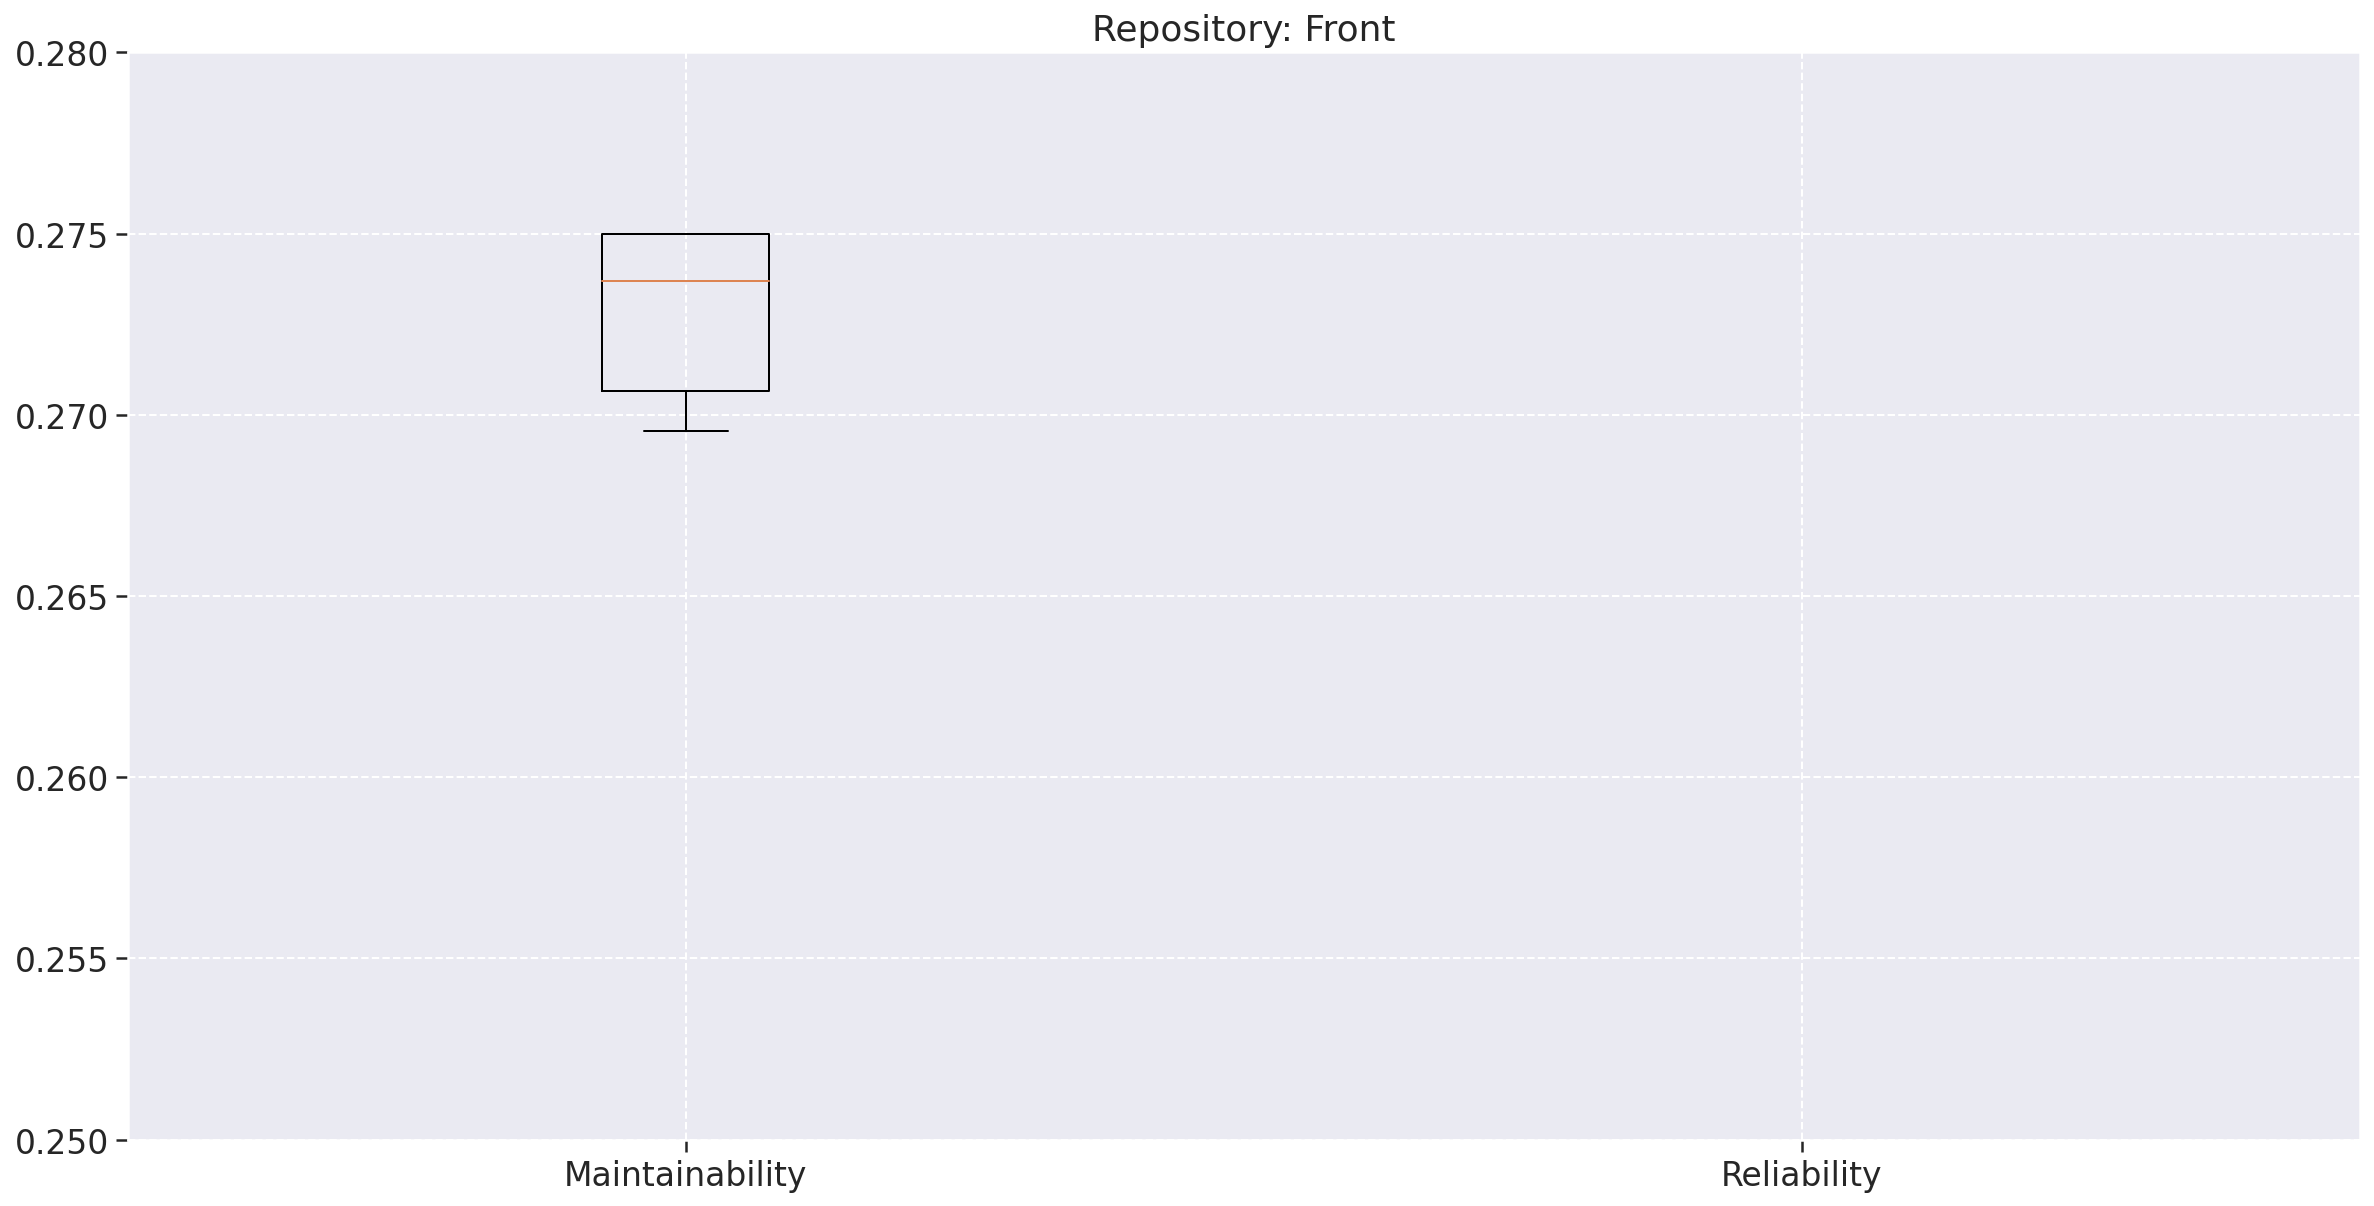

In [35]:
fig = plt.figure(figsize=(20, 10))

plt.title('Repository: Front')
plt.boxplot([front_metrics['Maintainability'], front_metrics['Reliability']], labels=['Maintainability','Reliability'])
plt.ylim(.25,.28)


### Reliability and Maintainability over time (only for repo with most releases)

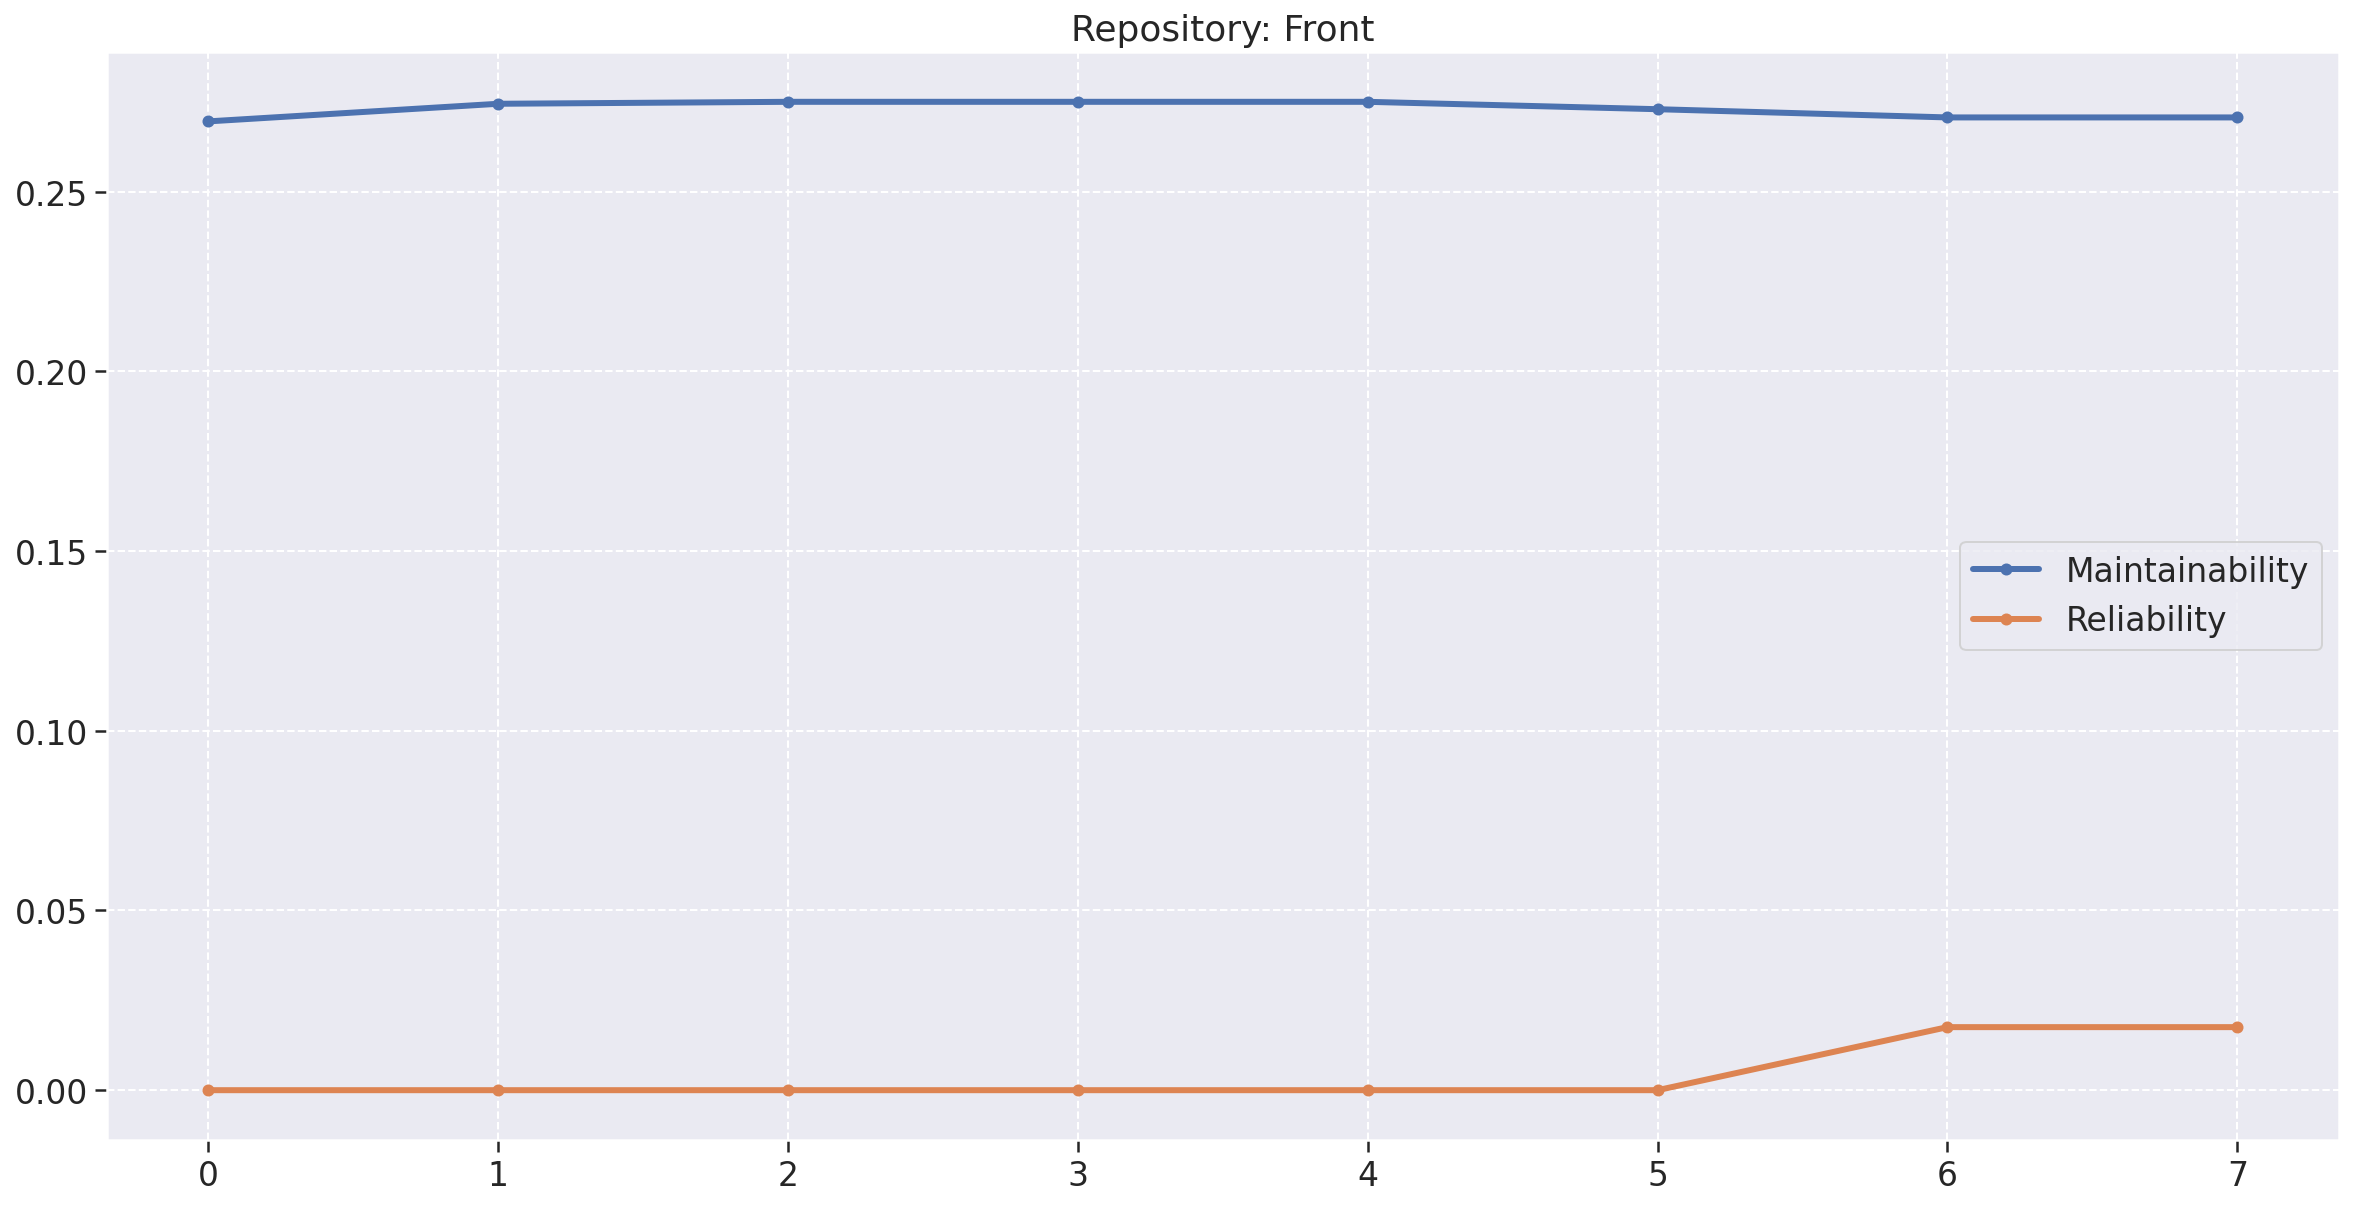

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.title('Repository: Front')
plt.plot(front_metrics['Maintainability'], linewidth=3, marker='o', markersize=5, label='Maintainability')
plt.plot(front_metrics['Reliability'], linewidth=3, marker='o', markersize=5, label='Reliability')
plt.legend()

## Total_QR analysis, considering metrics of all repositories

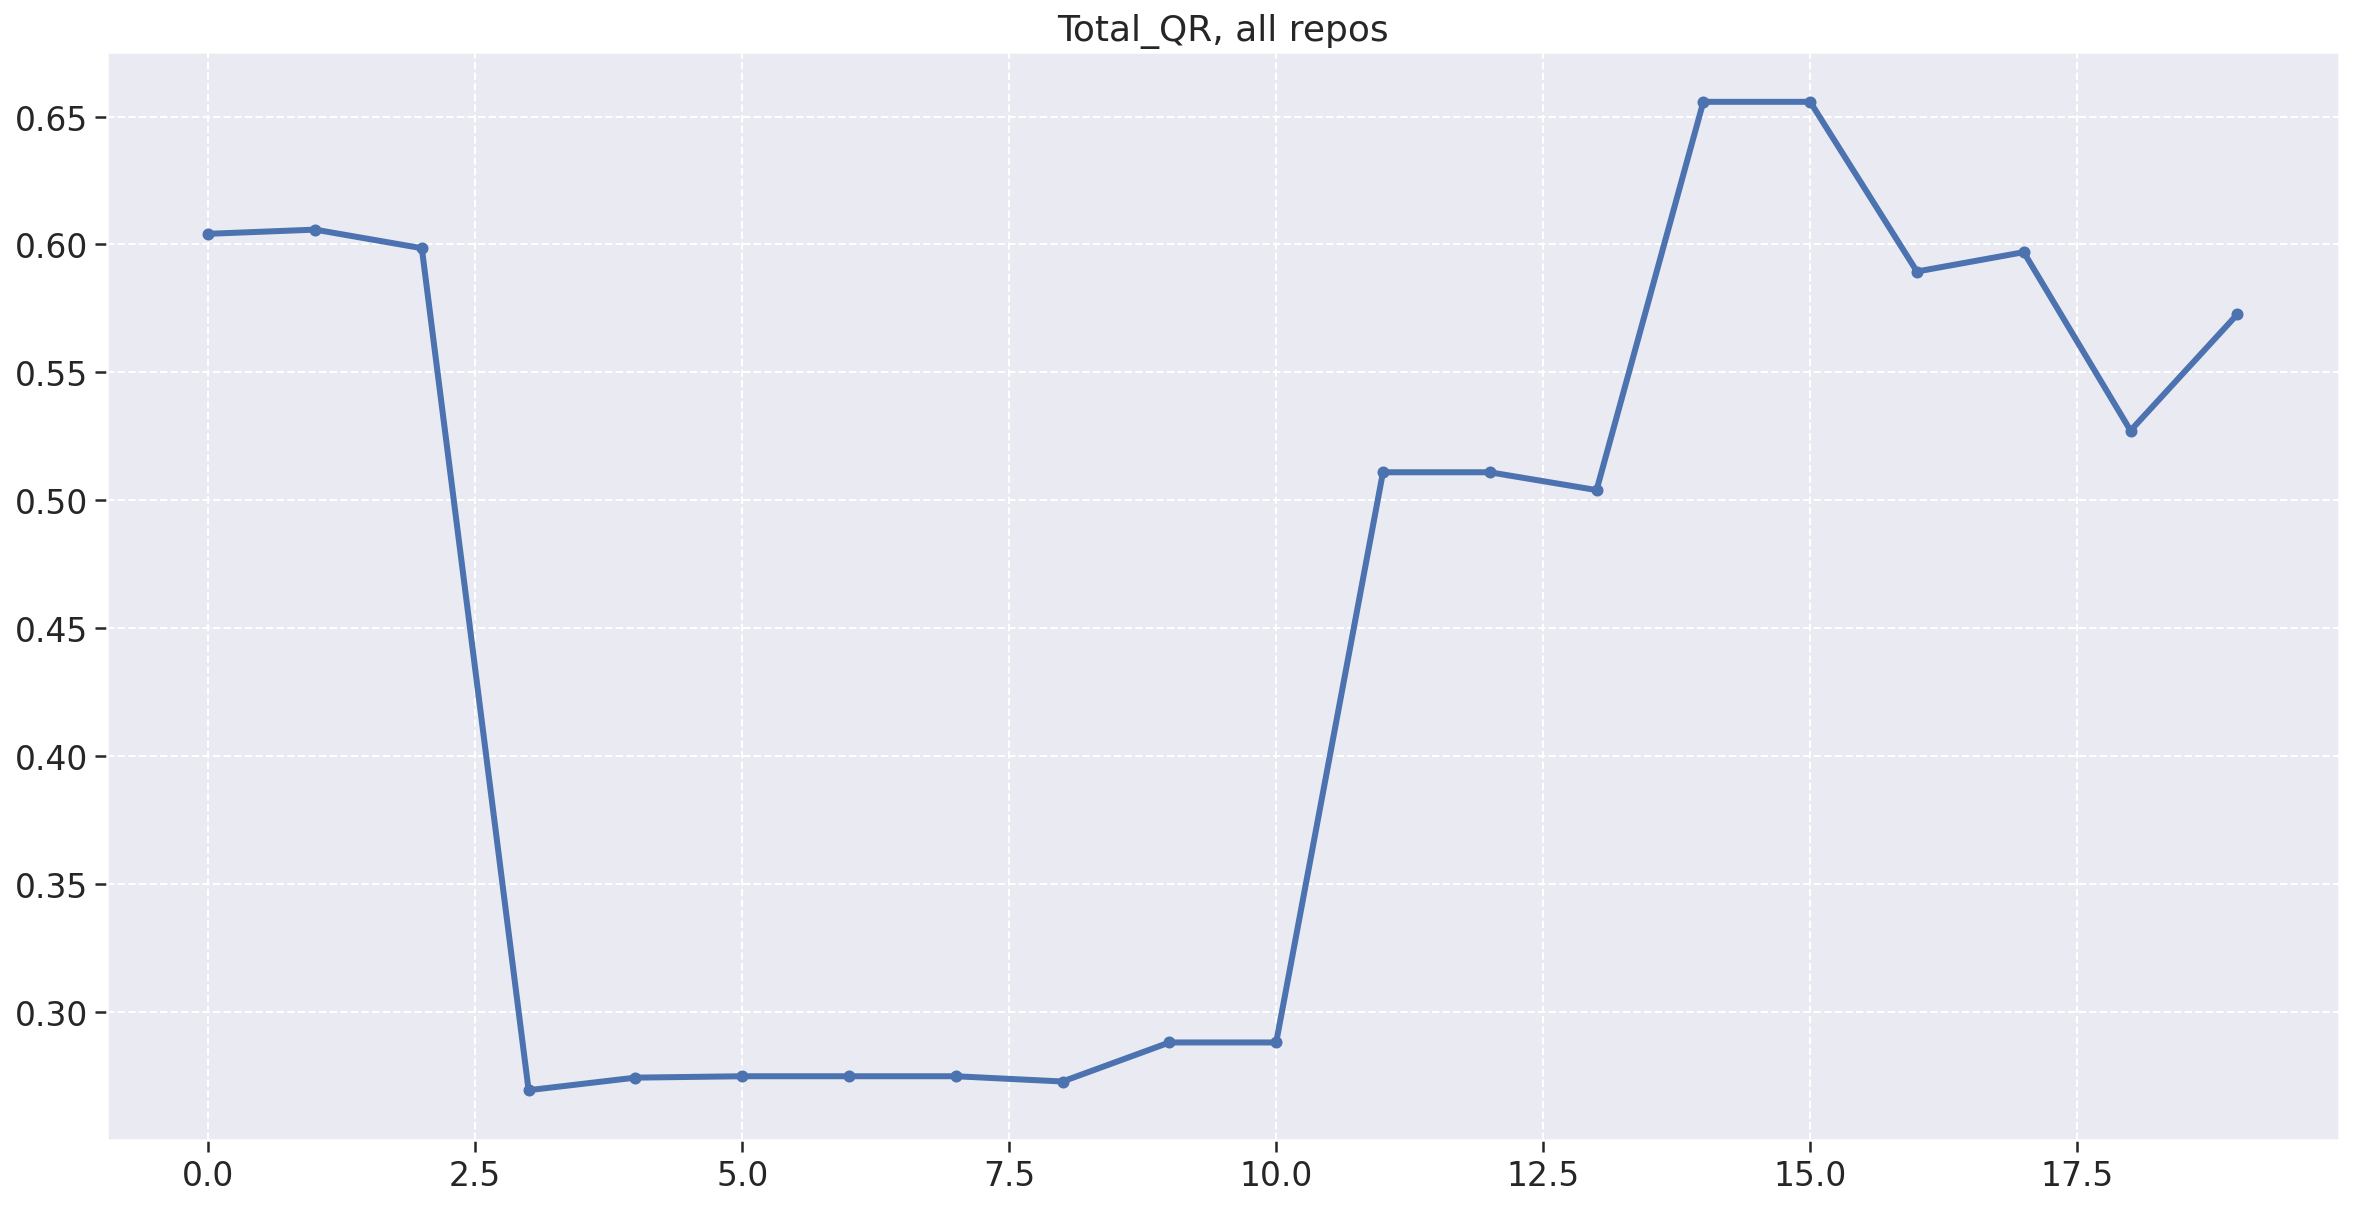

In [25]:
total_metrics_df = pd.concat(all_repo_measurements, ignore_index=True)
total_metrics_df['Maintainability'] = total_metrics_df['code_quality'] * pc1
total_metrics_df['Reliability'] = total_metrics_df['testing_status'] * pc2
total_metrics_df['Total_QR'] = total_metrics_df['Maintainability'] + total_metrics_df['Reliability']


fig = plt.figure(figsize=(20, 10))
plt.title('Total_QR, all repos')
plt.plot(total_metrics_df['Total_QR'], linewidth=3, marker='o', markersize=5)


### Análise do grupo
Pelo comportamento dos indicadores de qualidade podemos ver que o resultado geral começou em queda e foi aos poucos subindo. Isso se deve principalmente ao fato de que no inicio do projeto o grupo possuia poquíssemo conhecimento sobre as partes do sistema. E grande parte do grupo também possuía poquíssemo ou nenhum conhecimento das técnologias utilizadas no desenvolvimento. 

Dessa forma, no inicio do projeto, era muito difícil produzir códigos que resultassem em bons indicadores de qualidade. Visto que simplesmente desenvolver códigos que funcionavam já era um enorme desafio. Fato que se insensificou mais ainda com o objetivo de algumas funcionalidades, que também eram complexos. 

Conforme o conhecimento do grupo aumentou em cada uma dessas categorias, a qualidade foi aumentando significamente a cada entrega. Perto do final houve uma nova queda, associada a complexidade das ultimas funcionalidades entregues, mas que ainda manteve um patamar bem acima dos menores valores vistos na etapa inicial.

Ademais, existe um repositório específico que puxa o indicador geral de qualidade especialmente para baixo. Que é o repositório "front". Esse reposítorio contem o aplicativo de celular desenvolvido. É o repositório com mais releases, e também onde é mais difícil desenvolver novas funcionalidades. Quando o grupo atual iniciou o projeto do semestre, essa parte do projeto não tinha nenhum teste unitário. Nem mesmo as ferramentas para execução de testes na técnologia utilizada estavam configuradas.

Por conta disso, mesmo o grupo tendo tido o esforço de configurar os testes nesse repositório e de escrever alguns testes unitários para as funcionalidades mais importantes, a cobertura desse repositório em específico ainda ficou muito baixa. Visto que não foi possível testar essa grande gama de funcionalidades que já iniciaram no projeto no semestre atual sem teste nenhum. 

Finalmente, o grupo concluí que apesar de os indicadores estarem muito sucetíveis a melhoria, principalmente no repositório "front", conseguir a recuperação da qualidade após a queda no inicio do projeto foi um aprendizado muito importante para todos os membros.

Adicionalmente, nas visualizações extras abaixo é possível ver também os indicadores indivíduais de cada um dos repositórios. Pelas quais é possível ver por exemplo que a cobertura geral de teste é significativamente maior que no caso específico do repositório "front". 

## Visualizações extras

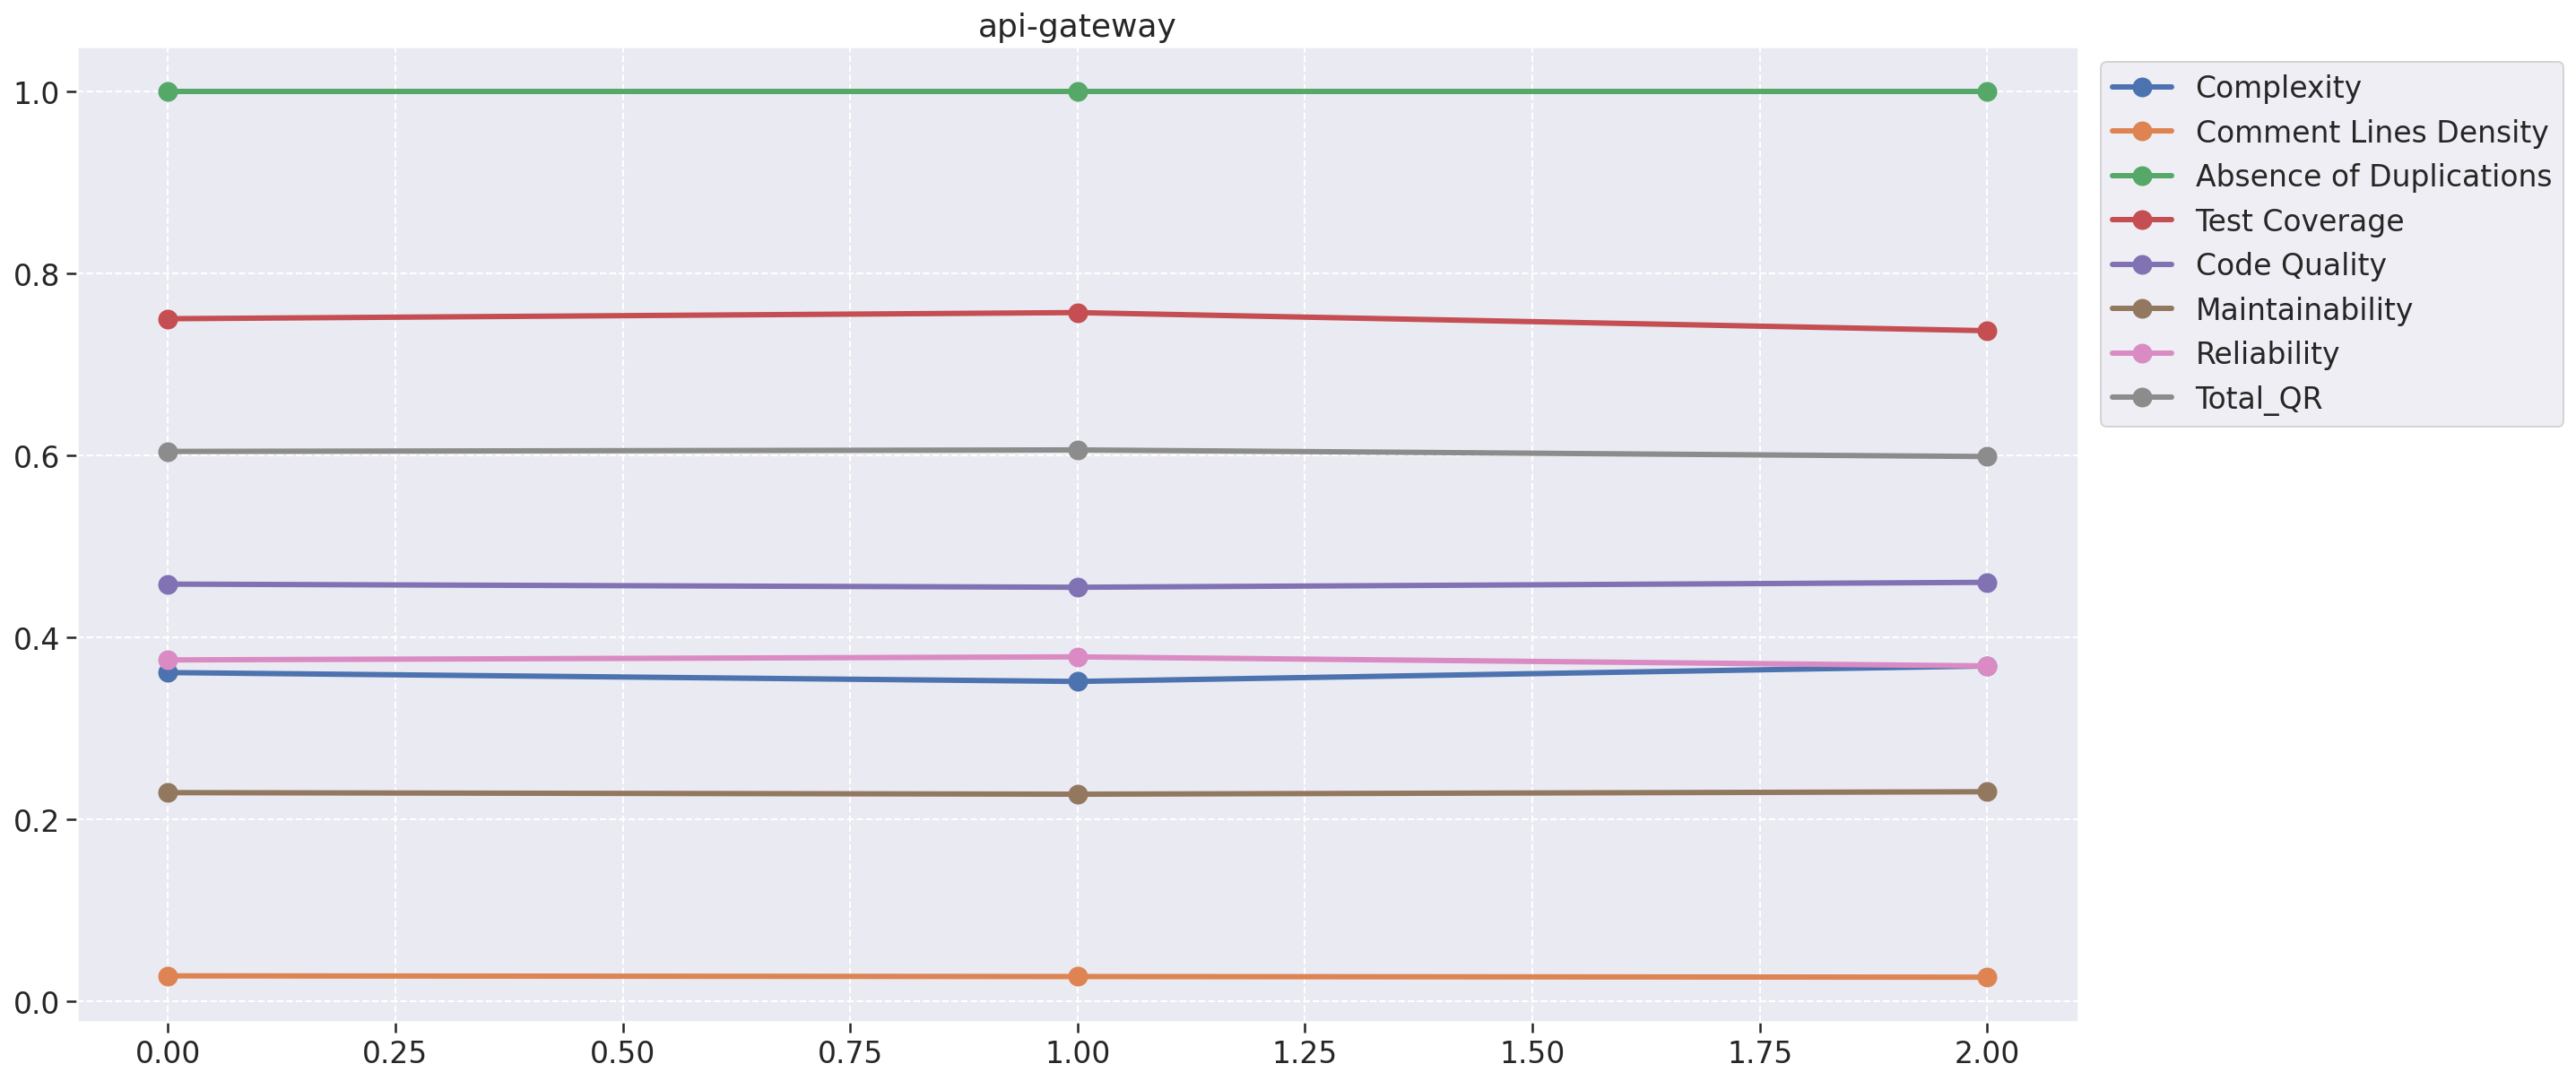

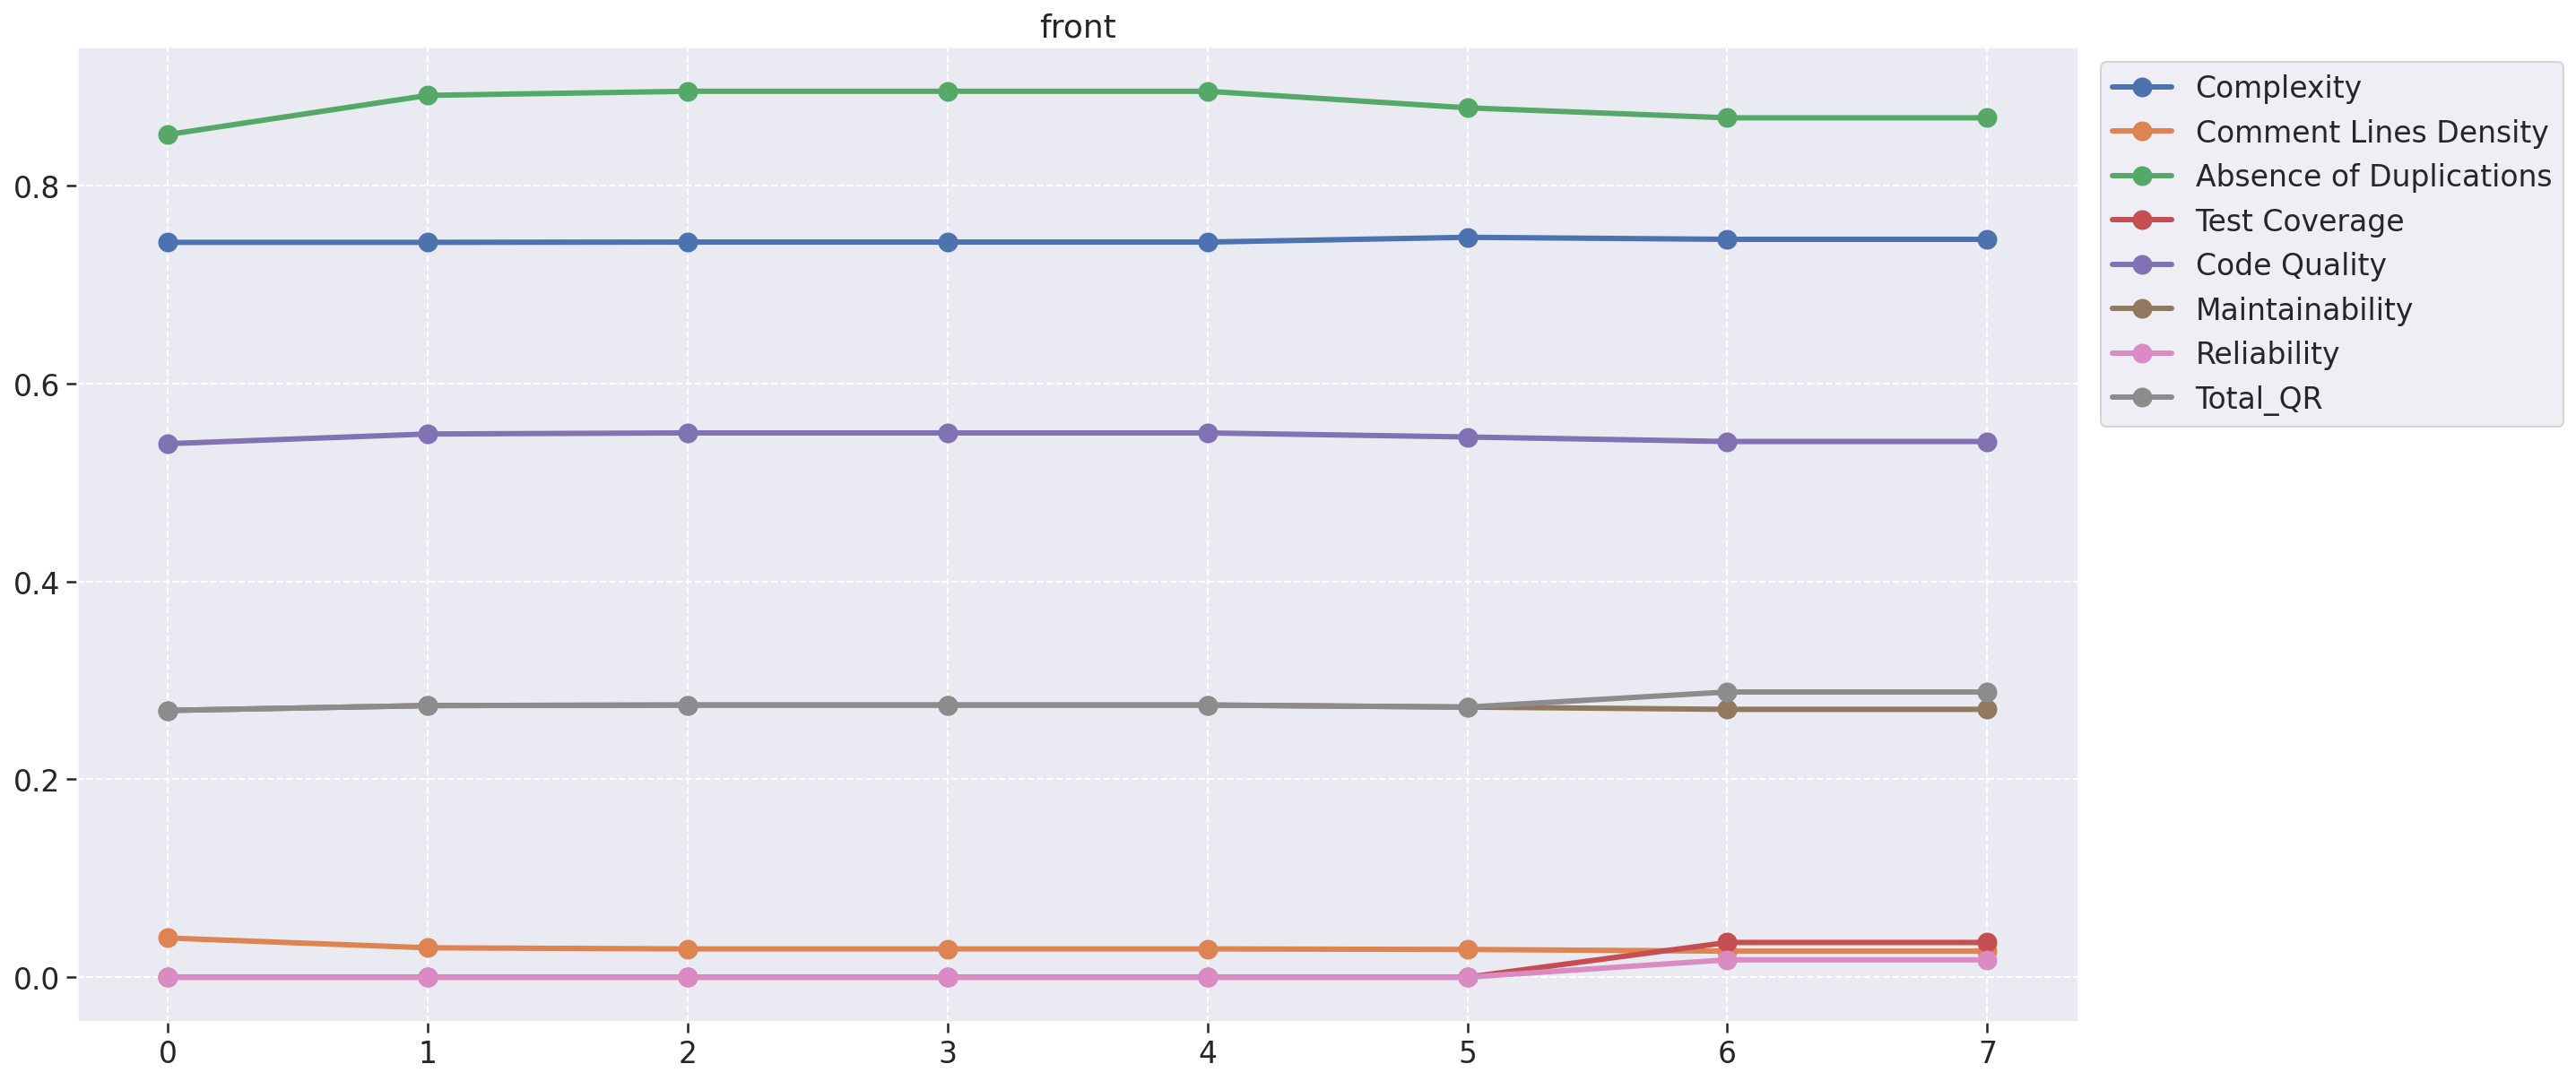

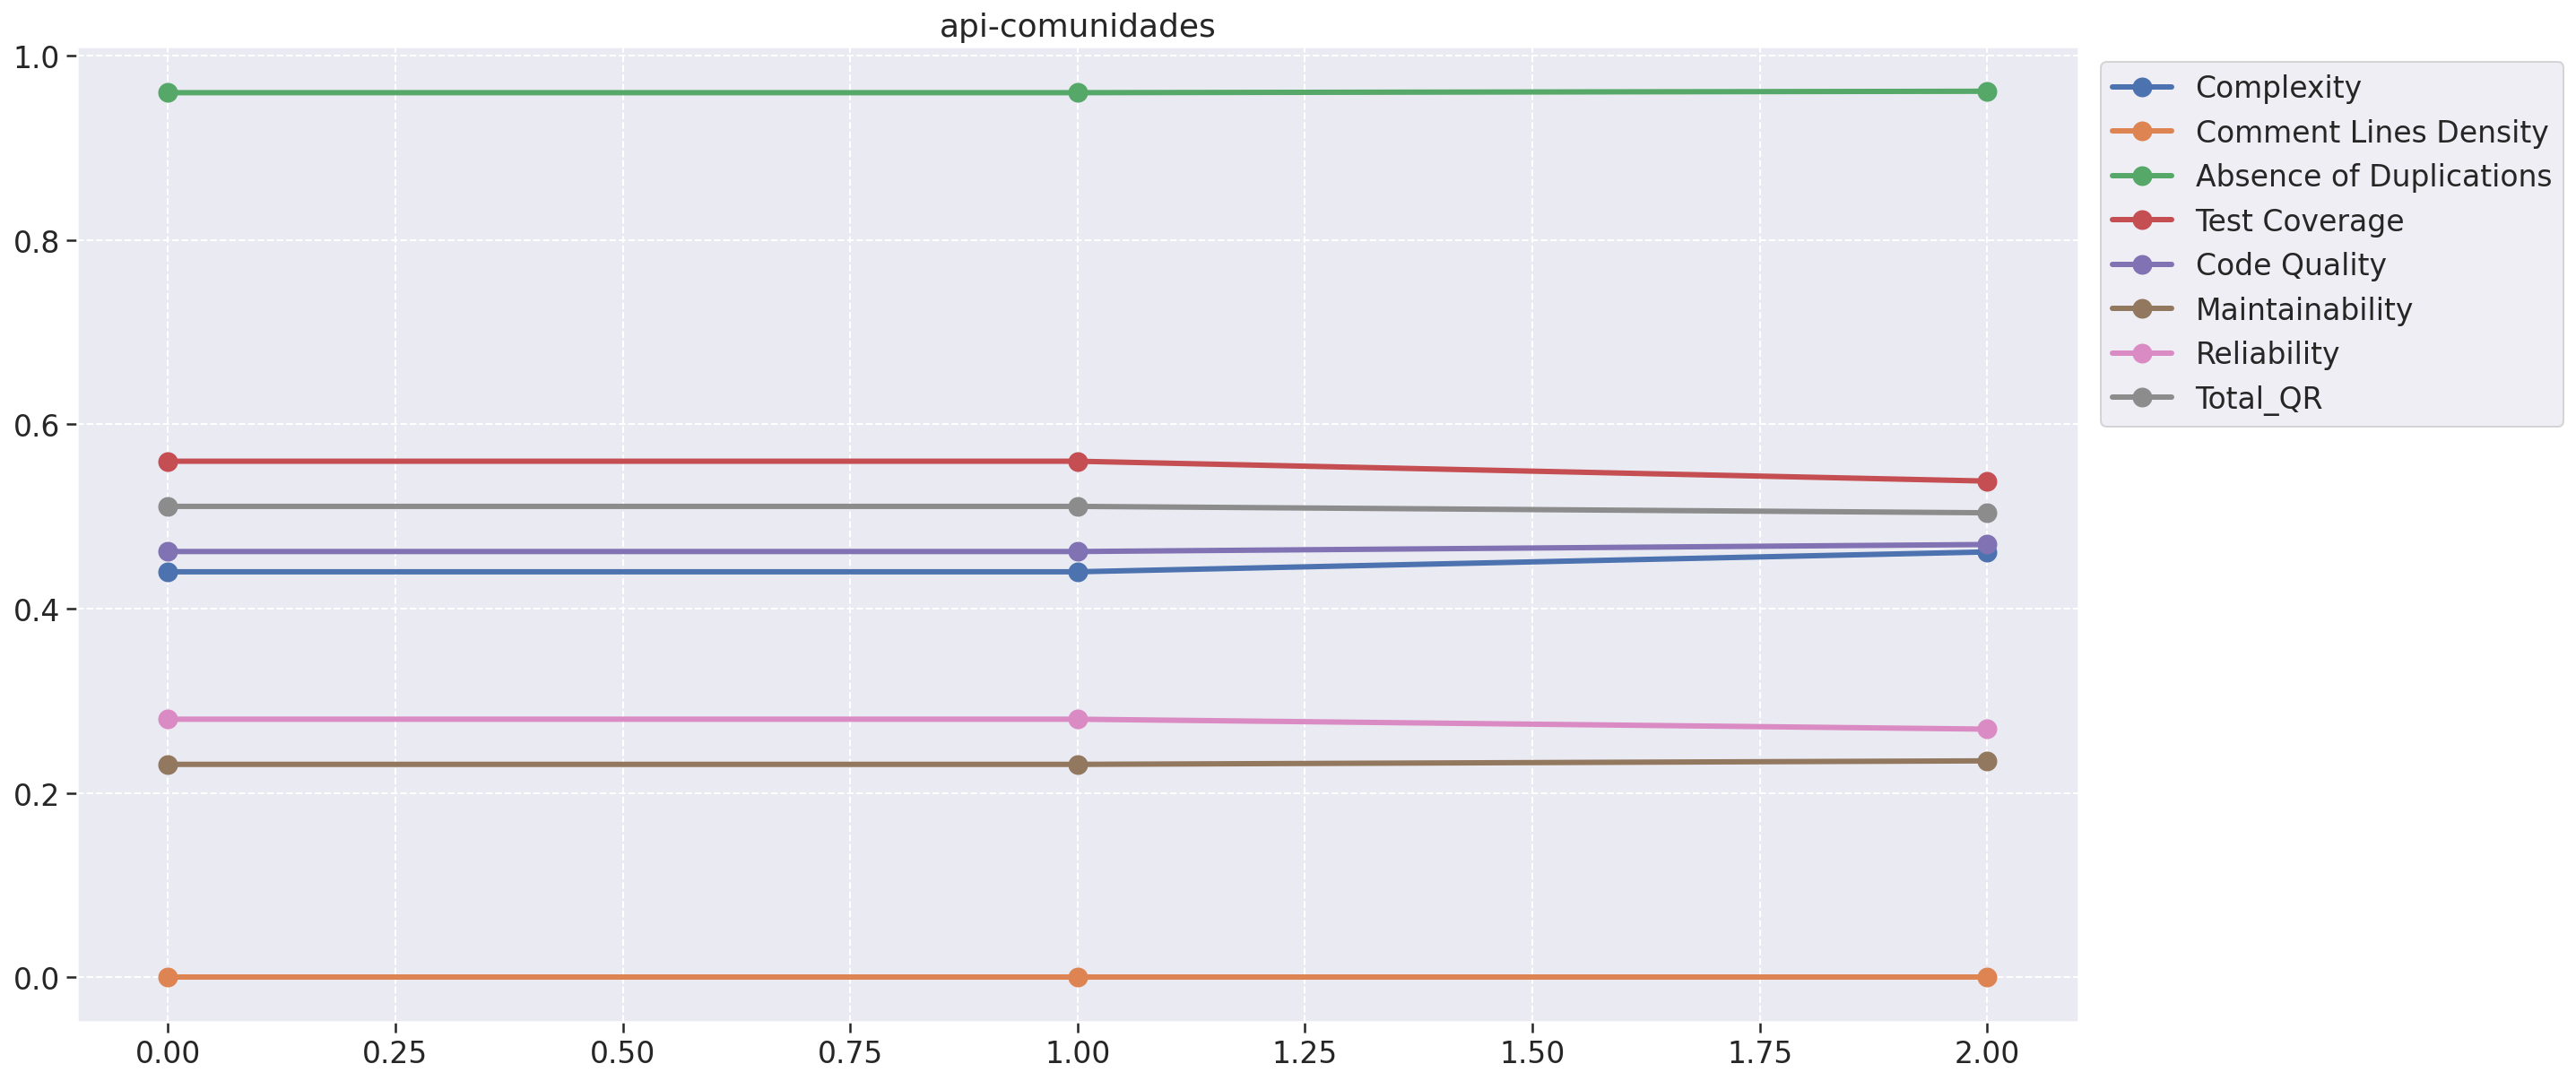

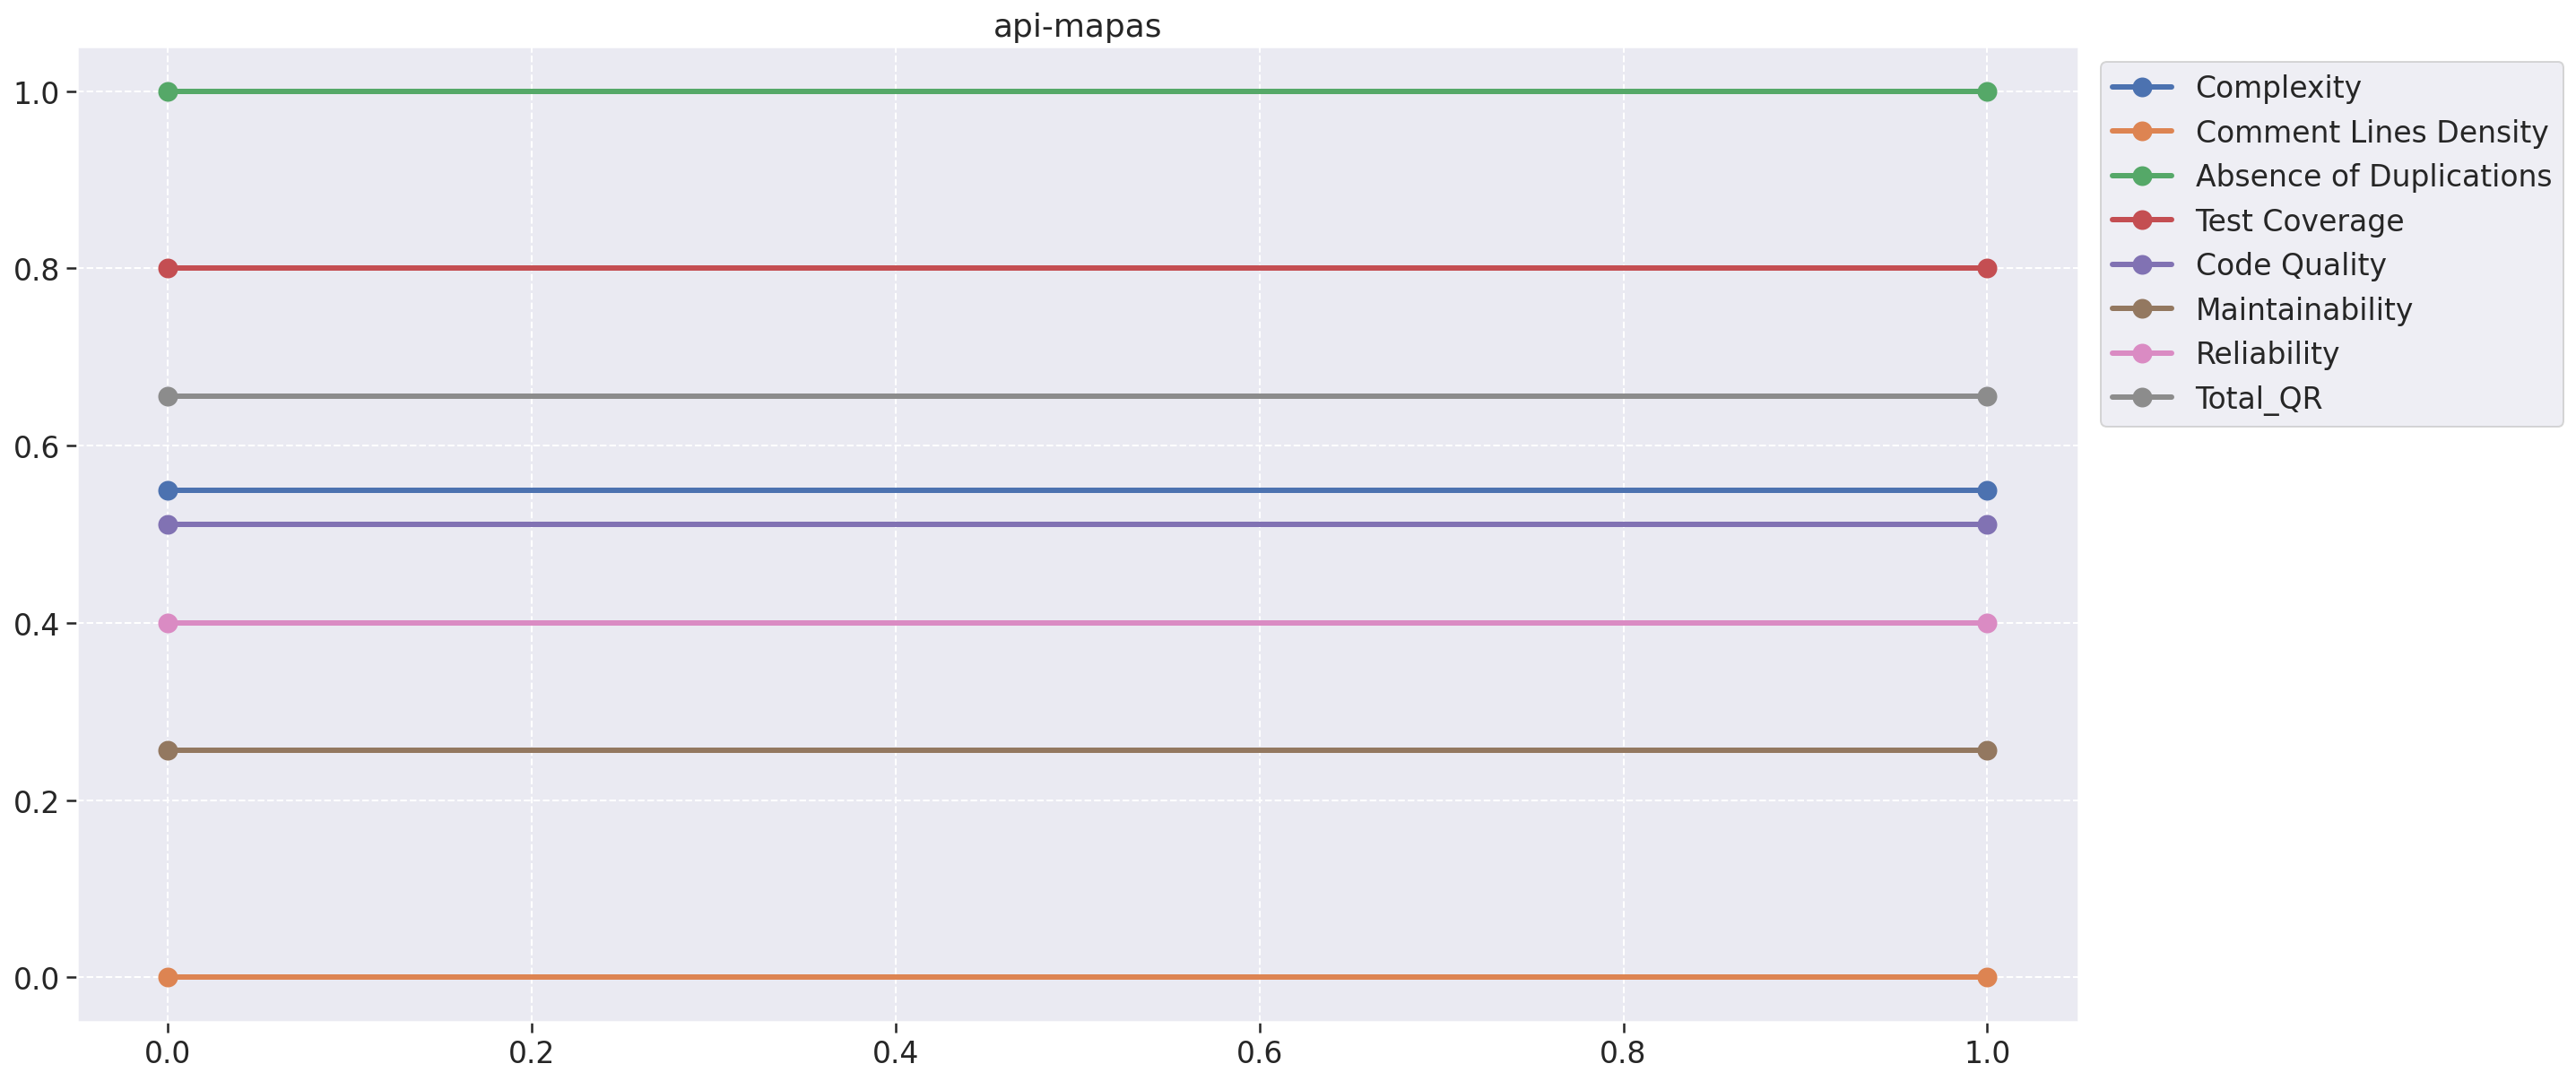

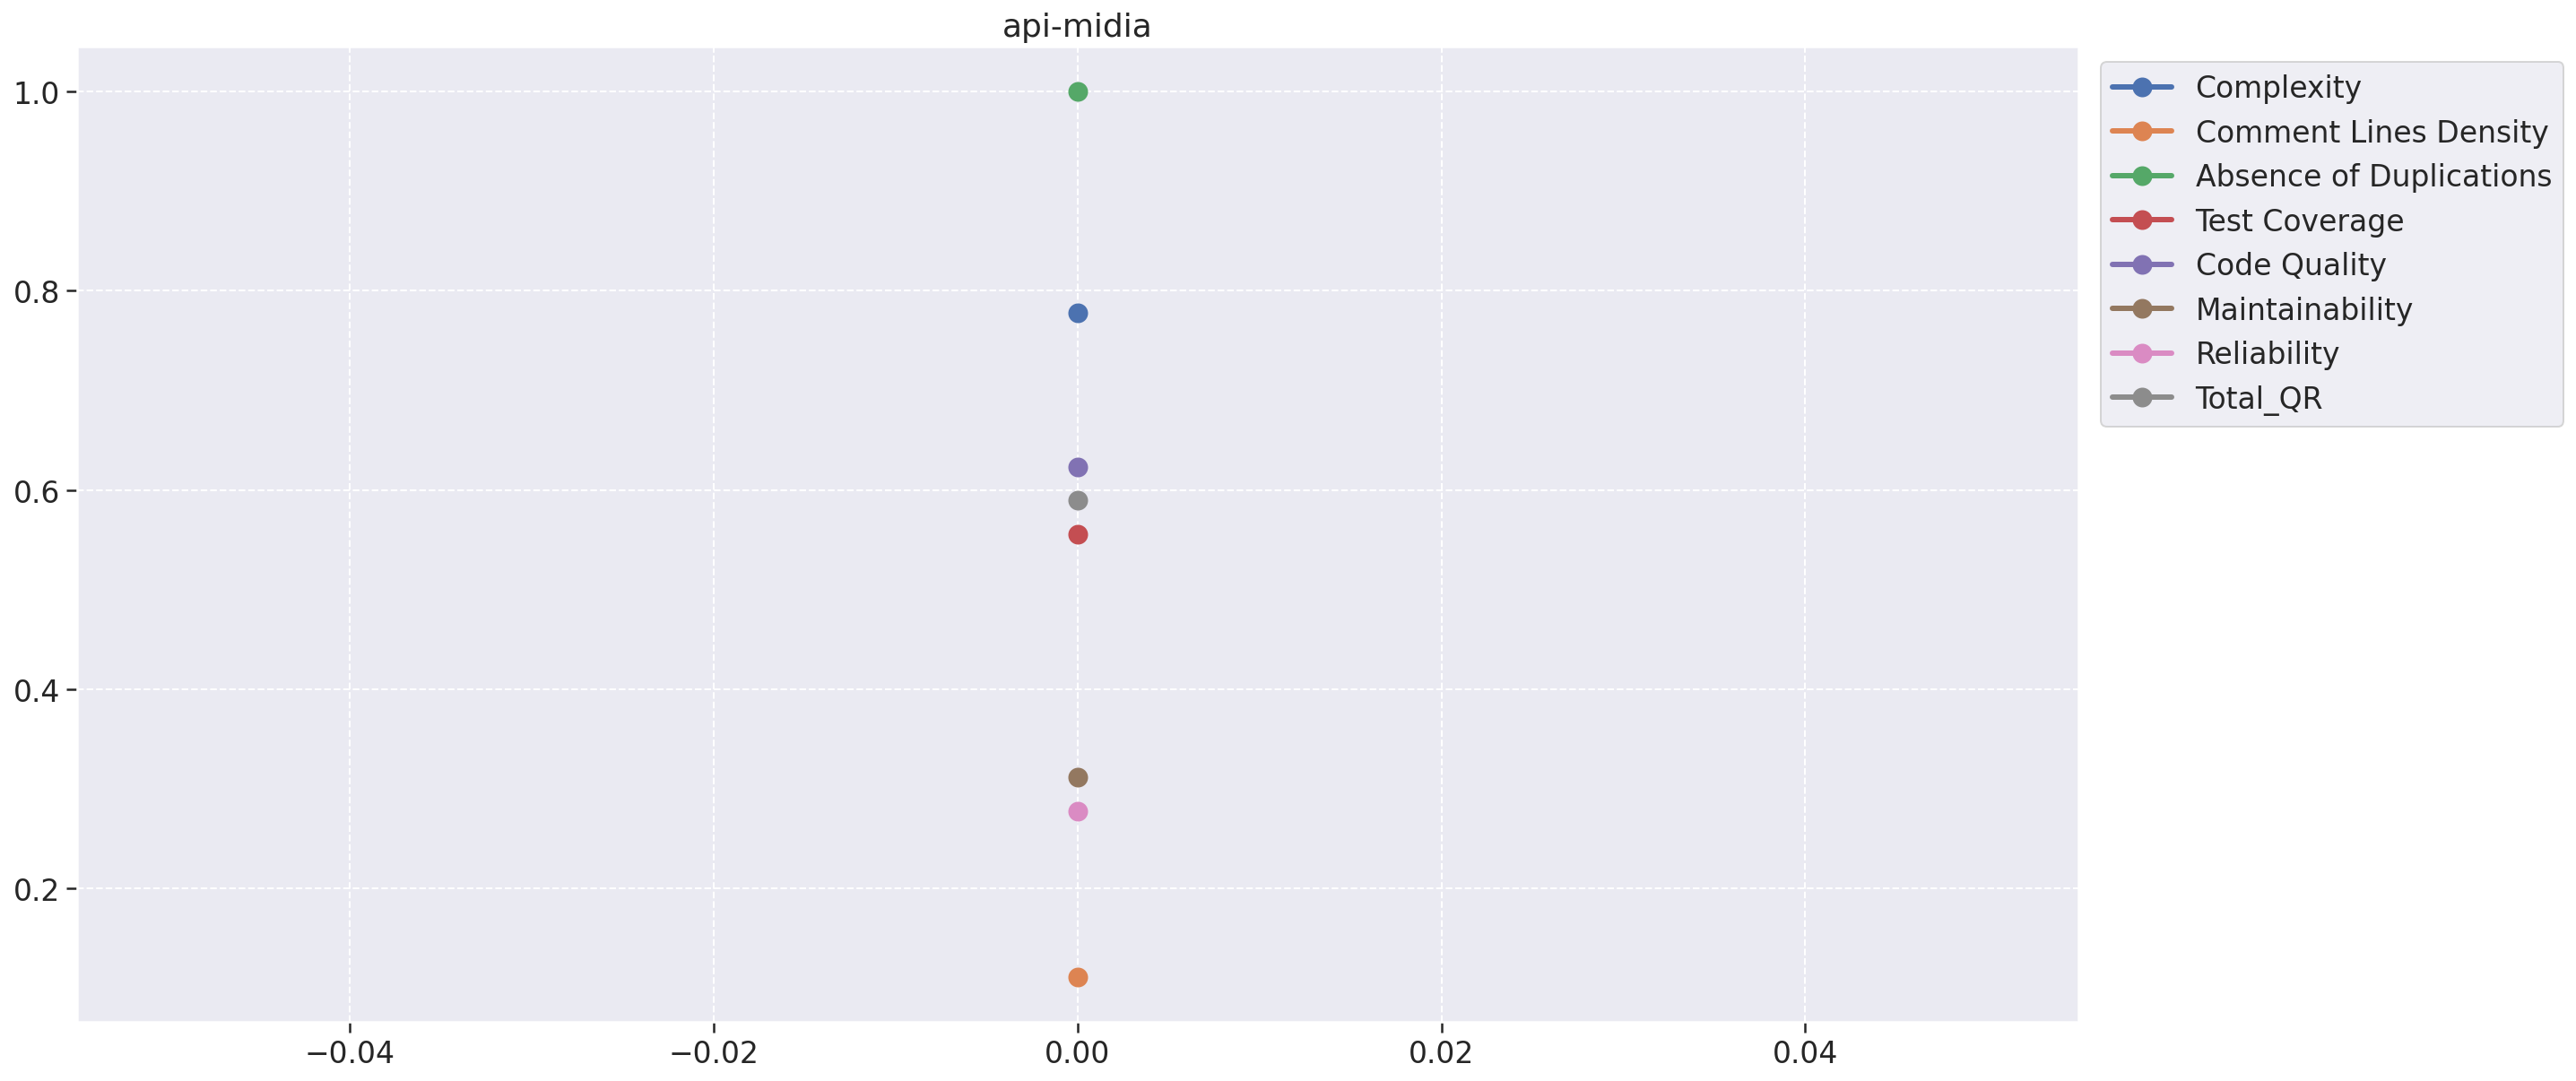

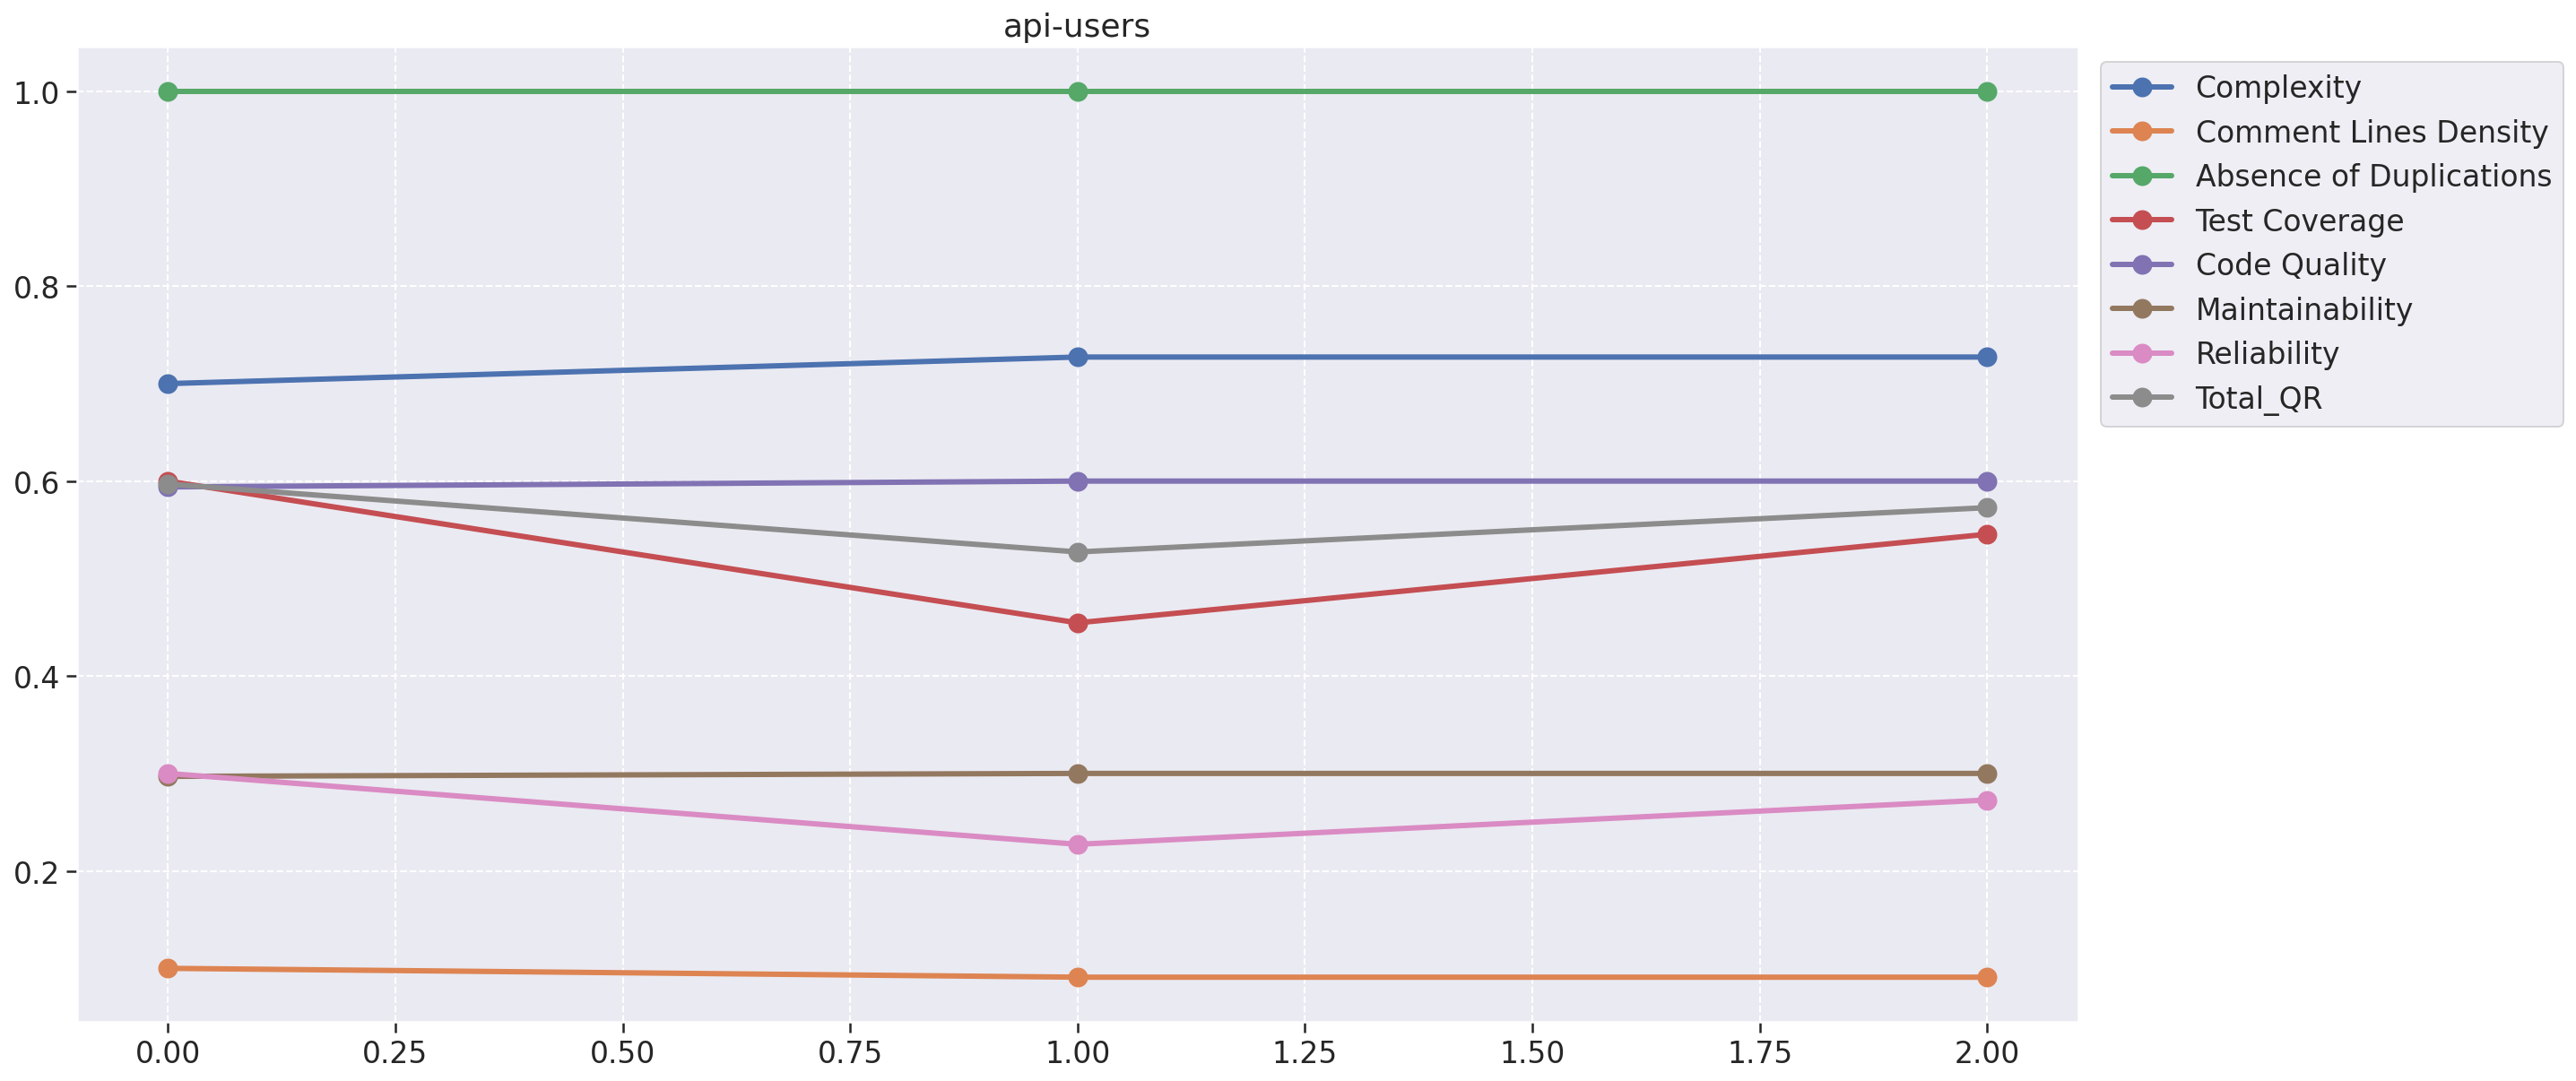

In [26]:
def build_graphic(selected_df):
    fig = plt.figure(figsize=(20, 10))
    plt.title(selected_df['Repository'].iloc[0])
    plt.plot(selected_df['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
    plt.plot(selected_df['m2'], linewidth=3, marker='o', label='Comment Lines Density', markersize=10)
    plt.plot(selected_df['m3'], linewidth=3, marker='o', label='Absence of Duplications', markersize=10)
    plt.plot(selected_df['m6'], linewidth=3, marker='o', label='Test Coverage', markersize=10)
    plt.plot(selected_df['code_quality'], linewidth=3, marker='o', label='Code Quality', markersize=10)
    plt.plot(selected_df['Maintainability'], linewidth=3, marker='o', label='Maintainability', markersize=10)
    plt.plot(selected_df['Reliability'], linewidth=3, marker='o', label='Reliability', markersize=10)
    plt.plot(selected_df['Total_QR'], linewidth=3, marker='o', label='Total_QR', markersize=10)
    plt.legend(bbox_to_anchor=(1.25,1), loc="upper right")

for repo in all_repo_measurements:
    build_graphic(repo)

## Persistência dos arquivos

Finalmente, para cada repositório, as métricas m1, m2, m3, m6 e LOC são persistidas. Bem como as informações Repository, Version, Date, Maintainability, Reliability e Total_QR. A persistência é feita tanto em CSV quanto em XLSX

In [27]:
def drop_unecessary(repo_metrics_df):
    repo_metrics_df.drop('code_quality', axis=1, inplace=True, errors='ignore')
    repo_metrics_df.drop('testing_status', axis=1, inplace=True, errors='ignore')

currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
for repo in all_repo_measurements:
    drop_unecessary(repo)
    repo_name = repo['Repository'].iloc[0]
    repo.to_excel('data/fga-eps-mds-2021-2-Cartografia-social-{}-{}.xlsx'.format(repo_name,currentDateTime), index = False)
    repo.to_csv('data/fga-eps-mds-2021-2-Cartografia-social-{}-{}.csv'.format(repo_name,currentDateTime), index = False)